# Chapter 3

This notebook contains the commands that are shown in the lecture 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Grouping data by a common variable

### Description of data - Triton cluster file statistics


[read_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)

[Timedelta](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html)

In [2]:
def load_filesizes(filesizes_file):
    filesizes = pd.read_table(filesizes_file, sep='\s+', names=['Bytes','MonthsTo2021', 'Files'])
    
    # Remove empty files
    filesizes = filesizes[filesizes.loc[:,'Bytes'] != 0]
    # Create a column for log2 of bytes
    filesizes['BytesLog2'] = np.log2(filesizes.loc[:, 'Bytes'])
    filesizes.loc[:,'BytesLog2'] = filesizes.loc[:,'BytesLog2'].astype(np.int64)
    # Determine total space S used by N files of size X during date D: S=N*X 
    filesizes['SpaceUsage'] = filesizes.loc[:,'Bytes']*filesizes.loc[:,'Files']
    # Determine file year and month from the MonthsTo2021-column
    filesizes['TotalMonths'] = 2021*12 - filesizes['MonthsTo2021'] - 1
    filesizes['Year'] = filesizes['TotalMonths'] // 12
    filesizes['Month'] = filesizes['TotalMonths'] % 12 + 1
    filesizes['Day'] = 1
    
    # Set year for really old files and files with incorrect timestamps
    invalid_years = (filesizes['Year'] < 2010) | (filesizes['Year'] > 2020)
    filesizes.loc[invalid_years, ['Year','Month']] = np.NaN
    
    # Get month names for the correct ordering of Month categories
    month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()
    # Create Date
    filesizes['Date'] = pd.to_datetime(filesizes[['Year', 'Month', 'Day']])
    # Set Month
    filesizes['Month'] = pd.Categorical(filesizes['Date'].dt.month_name(), categories=month_names, ordered=True)
    # Set Month to be an ordered categorical with predefined levels 
    filesizes['Month'] = pd.Categorical(filesizes['Month'], categories=month_names, ordered=True)
    # Sort data based on Date and BytesLog2
    filesizes.sort_values(['Date','BytesLog2'], inplace=True)
    # Remove old columns
    filesizes.drop(['MonthsTo2021','TotalMonths', 'Day'], axis=1, inplace=True)
    return filesizes

filesizes = load_filesizes('../data/filesizes_timestamps.txt')
filesizes.head()

,Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date
287,1,5,0,5,2010.0,January,2010-01-01
451,2,3,1,6,2010.0,January,2010-01-01
627,4,27,2,108,2010.0,January,2010-01-01
822,8,136,3,1088,2010.0,January,2010-01-01
1057,16,208,4,3328,2010.0,January,2010-01-01


### Simple groupings and summaries - Calculating new files per year

In [3]:
# Drop rows with NaNs (invalid years)
newfiles_relevant = filesizes.dropna(axis=0)
# Pick relevant columns
newfiles_relevant = newfiles_relevant.loc[:,['Year','Files']]
newfiles_relevant.head()

,Year,Files
287,2010.0,5
451,2010.0,3
627,2010.0,27
822,2010.0,136
1057,2010.0,208


In [4]:
print(newfiles_relevant.shape)

newfiles_yearly_sum = newfiles_relevant.groupby('Year').agg('sum')

print(newfiles_yearly_sum.shape)
newfiles_yearly_sum.head()

(4698, 2)
(11, 1)


,Files
Year,
2010.0,5590287
2011.0,13197038
2012.0,17099900
2013.0,14755151
2014.0,26329321


In [5]:
newfiles_yearly_sum.reset_index(inplace=True)

newfiles_yearly_sum.head()

,Year,Files
0,2010.0,5590287
1,2011.0,13197038
2,2012.0,17099900
3,2013.0,14755151
4,2014.0,26329321


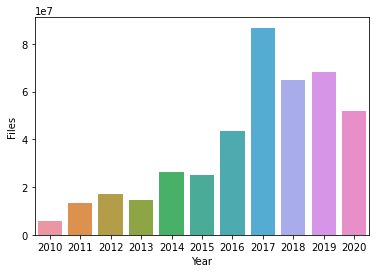

In [6]:
newfiles_yearly_sum['Year'] = newfiles_yearly_sum['Year'].astype(int).astype('category')
sb.barplot(x='Year', y='Files', data=newfiles_yearly_sum, ci=None)
plt.savefig('newfiles_yearly_sum_python.svg')

### Creating a function for many different summaries

In [7]:
def aggregate_filesize_data(data, groupings, targets, agg_function):
    # Drop rows with NaNs (invalid years)
    data_relevant = data.dropna(axis=0)
    # Pick relevant columns
    data_relevant = data_relevant.loc[:, groupings + targets]
    # Change grouping to category for prettier plotting
    data_relevant[groupings] = data_relevant[groupings].astype('category')

    # Aggregate data
    data_aggregated = data_relevant.groupby(groupings).agg(agg_function).reset_index()
    return data_aggregated

newfiles_yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files'], 'sum')
newfiles_yearly_sum.head()

,Year,Files
0,2010.0,5590287
1,2011.0,13197038
2,2012.0,17099900
3,2013.0,14755151
4,2014.0,26329321


   Year     Files      SpaceUsage
0  2010   5590287   2260716407068
1  2011  13197038   7000732111463
2  2012  17099900  15475575370580
3  2013  14755151  15445375302767
4  2014  26329321  42530364324322
      Month     Files      SpaceUsage
0   January  34921070  43131219269056
1  February  35707864  71022501061692
2     March  25494722  56516865081262
3     April  31224476  75382094990077
4       May  37816173  75338621861676


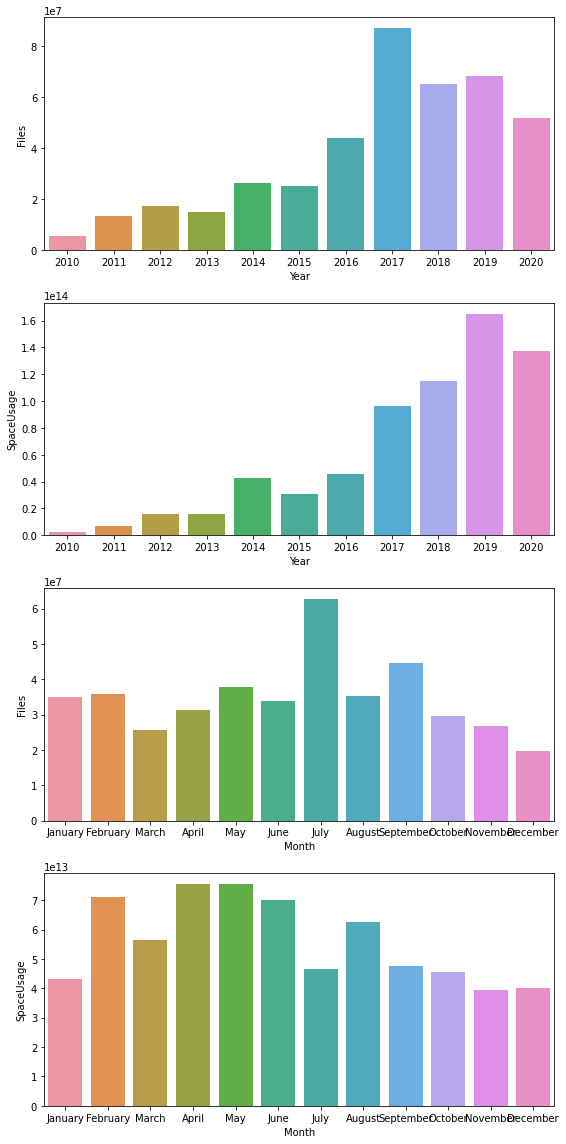

In [8]:
yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files', 'SpaceUsage'], 'sum')
monthly_sum = aggregate_filesize_data(filesizes, ['Month'], ['Files', 'SpaceUsage'], 'sum')

yearly_sum['Year'] = yearly_sum['Year'].astype(int).astype('category')

print(yearly_sum.head())
print(monthly_sum.head())

fig, ((ax1, ax2, ax3, ax4))=plt.subplots(nrows=4, figsize=(8,16))
sb.barplot(x='Year', y='Files', data=yearly_sum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=yearly_sum, ci=None, ax=ax2)
sb.barplot(x='Month', y='Files', data=monthly_sum, ci=None, ax=ax3)
sb.barplot(x='Month', y='SpaceUsage', data=monthly_sum, ci=None, ax=ax4)
plt.tight_layout()
plt.savefig('newall_python.svg')

## Fitting functions to data

In [9]:
yearly_cumsum = yearly_sum.copy()
yearly_cumsum.loc[:,['Files','SpaceUsage']] = yearly_cumsum[['Files','SpaceUsage']].cumsum()
yearly_cumsum.head()

,Year,Files,SpaceUsage
0,2010,5590287,2260716407068
1,2011,18787325,9261448518531
2,2012,35887225,24737023889111
3,2013,50642376,40182399191878
4,2014,76971697,82712763516200


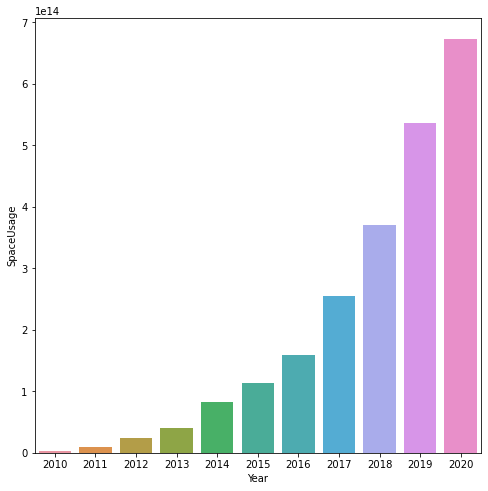

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
sb.barplot(x='Year', y='SpaceUsage', data=yearly_cumsum, ci=None, ax=ax)
plt.savefig('cumulative-space-usage_python.svg')

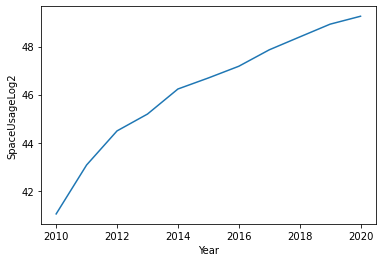

In [11]:
yearly_cumsum['SpaceUsageLog2'] = yearly_cumsum['SpaceUsage'].apply(np.log2)

fig, ax = plt.subplots(figsize=(6,4))
sb.lineplot(x='Year', y='SpaceUsageLog2', data=yearly_cumsum, ci=None, ax=ax)
plt.savefig('cumulative-logspace-usage_python.svg')

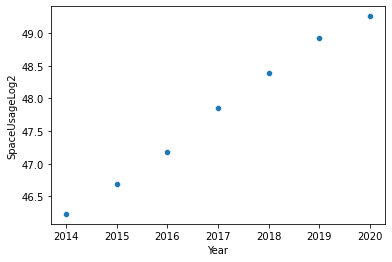

In [12]:
fit_dataset = yearly_cumsum.copy()
fit_dataset['Year'] = fit_dataset['Year'].astype(int)
fit_dataset = fit_dataset[fit_dataset['Year'] > 2013]

fig, ax = plt.subplots(figsize=(6,4))
sb.scatterplot(x='Year', y='SpaceUsageLog2', data=fit_dataset, ci=None, ax=ax)
plt.savefig('cumulative-logspace-usage-fitrange_python.svg')

In [13]:
from sklearn import linear_model

# Set up a linear model
model1 = linear_model.LinearRegression()
# Fit to the linear model. Notice that first argument needs to be 2D.
model1.fit(fit_dataset[['Year']],fit_dataset['SpaceUsageLog2'])
# Print model coefs
print(model1.coef_, model1.intercept_)

[0.52740083] -1015.9746062919537


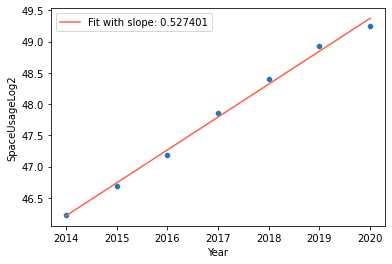

In [14]:
# Predict based on our model
fit_dataset['SpaceUsagePredictedLog2'] = model1.predict(fit_dataset[['Year']])

# Plot the data and our model
sb.scatterplot(x='Year', y='SpaceUsageLog2', data=fit_dataset, ci=None)
sb.lineplot(x='Year', y='SpaceUsagePredictedLog2', data=fit_dataset, color='tomato', label='Fit with slope: %f' % model1.coef_)
plt.savefig('fit-logspace-model1_python.svg')

[ 5.27400831e-01 -1.01597461e+03]


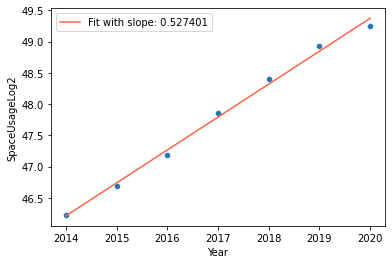

In [15]:
from scipy.optimize import curve_fit

# Set up a linear model
def model2(x, a, b):
    return a*x + b

# Fit to the linear model
coefs,_ = curve_fit(model2, fit_dataset['Year'], fit_dataset['SpaceUsageLog2'])

# Print model coefs
print(coefs)

# Predict based on our model
fit_dataset['SpaceUsagePredictedLog2'] = model2(fit_dataset['Year'], *coefs)

# Plot the data and our model
sb.scatterplot(x='Year', y='SpaceUsageLog2', data=fit_dataset, ci=None)
sb.lineplot(x='Year', y='SpaceUsagePredictedLog2', data=fit_dataset, color='tomato', label='Fit with slope: %f' % coefs[0])
plt.savefig('fit-logspace-model2_python.svg')

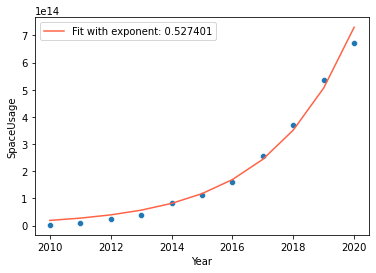

In [16]:
fit_dataset = yearly_cumsum.copy()
fit_dataset['Year'] = fit_dataset['Year'].astype(int)

def fit_exponential(dataset, x_column, y_column, fit_range=None):
    
    fit_dataset = dataset
    
    # If fit_range is defined, limit fit to that range
    if fit_range is not None:
        fit_dataset = fit_dataset.loc[fit_range, :]

    # Set up a linear model
    def linear_model(x, a, b):
        return a*x + b
    
    y_log = np.log2(fit_dataset[y_column])
    
    # Fit to the linear model
    coefs,_ = curve_fit(linear_model, fit_dataset[x_column], y_log)
    
    # Predict based on our model
    dataset['Predicted'] = 2 ** linear_model(dataset[x_column], *coefs)

    return dataset, coefs

fit_dataset_final, coefs = fit_exponential(fit_dataset, 'Year', 'SpaceUsage', fit_dataset['Year'] > 2013)

sb.scatterplot(x='Year', y='SpaceUsage', data=fit_dataset_final, ci=None)
sb.lineplot(x='Year', y='Predicted', data=fit_dataset_final, color='tomato', label='Fit with exponent: %f' % coefs[0])
plt.savefig('fit-space-function_python.svg')

## Using bootstrapping/resampling methods for the calculation of statistical moments

### Quick overview of bootstrapping

In [17]:
# Drop rows with NaNs (invalid years)
newfiles_relevant2 = filesizes.dropna(axis=0)
# Pick relevant columns
newfiles_relevant2 = newfiles_relevant2.loc[:,['Year','BytesLog2','Files']]
# Aggregate based on Year and BytesLog2
newfiles_yearly_sum2 = newfiles_relevant2.groupby(['Year','BytesLog2']).agg('sum')

newfiles_yearly_sum2.head()

Files
Year   BytesLog2       
2010.0 0            124
       1           1632
       2           5626
       3          26287
       4          65074

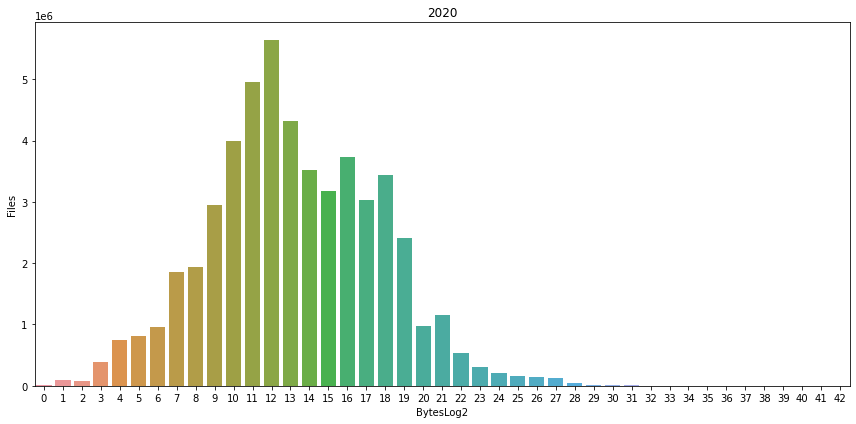

In [18]:
yearly_bytes_sum = aggregate_filesize_data(filesizes, ['Year','BytesLog2'], ['Files', 'SpaceUsage'], 'sum')

bytes_2020 = yearly_bytes_sum[yearly_bytes_sum['Year'] == 2020]

plt.figure(figsize=(12,6))
sb.barplot(x='BytesLog2', y='Files', data=bytes_2020, ci=None)
plt.title(2020)
plt.tight_layout()
plt.savefig('file-distribution-2020_python.svg')

In [19]:
# Pick target data column and convert it to integer
target_data = bytes_2020['BytesLog2'].copy().astype('int')
# Pick weight data column
weight_data = bytes_2020['Files'].copy()

# IMPORTANT:
#    There might be categories in BytesLog2 that do not contain any data.
#    We'll have to fill zeros to those rows of Files.
weight_data.fillna(0, inplace=True)

# Normalize weight_data into probabilities
weight_data = weight_data/weight_data.sum()

print(target_data.head())
print(weight_data.head())

430    0
431    1
432    2
433    3
434    4
Name: BytesLog2, dtype: int64
430    0.000327
431    0.001940
432    0.001471
433    0.007406
434    0.014570
Name: Files, dtype: float64


In [20]:
# Create means vector
means = np.zeros(10, dtype=np.float64)
for i in range(10):
    # Calculate resampled mean
    means[i] = np.mean(np.random.choice(target_data, 100, replace=True, p=weight_data))
print(means[:10])
print('Estimated sample mean:', np.mean(means))

[13.32 14.21 13.34 12.69 13.   13.94 13.02 12.65 13.88 12.64]
Estimated sample mean: 13.269


In [21]:
def get_bootstrapped_means(dataset, target_col, weight_col, n_means=1000):
    # Pick relevant columns
    df = dataset[[target_col, weight_col]].copy()
    # Pick target data column
    target_data = df[target_col]
    # Pick weight data column
    weight_data = df[weight_col]
    # Fill zeros to those byte sizes that are not present in the Files-data
    weight_data.fillna(0, inplace=True)
    # Normalize weight_data into probabilities
    weight_data = weight_data/weight_data.sum()
    
    # Create means vector
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        # Calculate resampled mean
        means[i] = np.mean(np.random.choice(target_data, 100, replace=True, p=weight_data))

    return means

bootstrapped_means = get_bootstrapped_means(bytes_2020, 'BytesLog2', 'Files', n_means=1000)
print(bootstrapped_means[:10])
print('Estimated sample mean:', np.mean(bootstrapped_means))

[13.18 13.31 13.04 13.71 14.11 13.08 13.14 14.24 13.18 11.98]
Estimated sample mean: 13.235149999999999


### Using nested dataframes to help with bootstrapping

In [22]:
bootstrapped_means = yearly_bytes_sum.groupby('Year').apply(lambda x: pd.Series({'data': x}))
bootstrapped_means.head()

,data
Year,
2010.0,Year BytesLog2 Files SpaceUsage ...
2011.0,Year BytesLog2 Files SpaceUsage ...
2012.0,Year BytesLog2 Files SpaceUsage...
2013.0,Year BytesLog2 Files SpaceUsage...
2014.0,Year BytesLog2 Files SpaceUsage...


In [23]:
bootstrapped_means['SampledMeans'] = bootstrapped_means['data'].apply(lambda x: get_bootstrapped_means(x, 'BytesLog2', 'Files', n_means=5))
bootstrapped_means.drop('data', axis=1, inplace=True)
bootstrapped_means.head()

,SampledMeans
Year,
2010.0,"[12.64, 11.97, 13.3, 13.2, 13.22]"
2011.0,"[14.26, 13.84, 13.44, 14.18, 14.36]"
2012.0,"[11.01, 10.42, 9.98, 11.05, 10.53]"
2013.0,"[12.23, 13.09, 13.82, 13.75, 13.63]"
2014.0,"[14.44, 13.83, 13.39, 13.74, 14.74]"


In [24]:
bootstrapped_means['Mean'] = bootstrapped_means['SampledMeans'].apply(np.mean)
bootstrapped_means.head()

,SampledMeans,Mean
Year,,
2010.0,"[12.64, 11.97, 13.3, 13.2, 13.22]",12.866
2011.0,"[14.26, 13.84, 13.44, 14.18, 14.36]",14.016
2012.0,"[11.01, 10.42, 9.98, 11.05, 10.53]",10.598
2013.0,"[12.23, 13.09, 13.82, 13.75, 13.63]",13.304
2014.0,"[14.44, 13.83, 13.39, 13.74, 14.74]",14.028


In [25]:
def bootstrap_byteslog2_mean(dataset, group_variable, target_variable, n_means=1000):

    bootstrapping_function = lambda x: get_bootstrapped_means(x, 'BytesLog2', target_variable, n_means=n_means)

    bootstrapped_means = dataset.groupby(group_variable).apply(lambda x: pd.Series({'data': x}))
    bootstrapped_means['SampledMeans'] = bootstrapped_means['data'].apply(bootstrapping_function)
    bootstrapped_means['Mean'] = bootstrapped_means['SampledMeans'].apply(np.mean)
    bootstrapped_means.drop('data', axis=1, inplace=True)
    return bootstrapped_means

bootstrapped_yearly_means = bootstrap_byteslog2_mean(yearly_bytes_sum, 'Year', 'Files', n_means=1000)
bootstrapped_yearly_means.head()

,SampledMeans,Mean
Year,,
2010.0,"[13.36, 12.53, 12.99, 13.09, 12.7, 13.05, 12.4...",12.99055
2011.0,"[13.83, 13.66, 14.43, 14.25, 14.2, 14.61, 13.6...",14.04335
2012.0,"[10.6, 10.78, 10.21, 10.76, 10.93, 10.6, 10.35...",10.69130
2013.0,"[13.78, 13.25, 13.78, 14.17, 13.04, 13.56, 13....",13.38955
2014.0,"[14.02, 14.45, 13.81, 14.29, 14.05, 13.93, 13....",14.03213


In [26]:
bootstrapped_yearly_means_distribution = bootstrapped_yearly_means.drop('Mean', axis=1).explode('SampledMeans').reset_index()

bootstrapped_yearly_means_distribution.head()

,Year,SampledMeans
0,2010.0,13.36
1,2010.0,12.53
2,2010.0,12.99
3,2010.0,13.09
4,2010.0,12.7


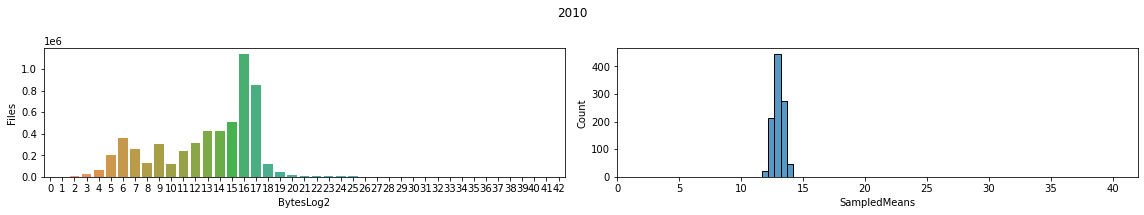

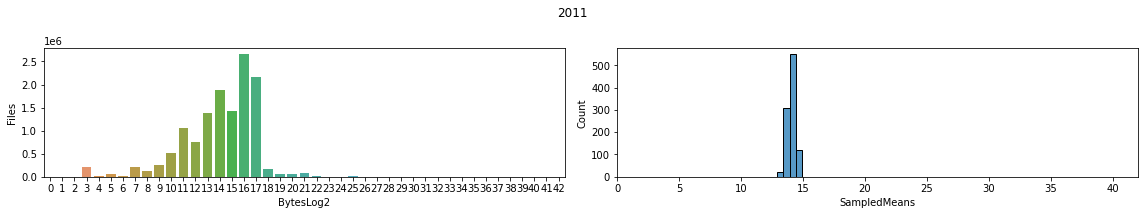

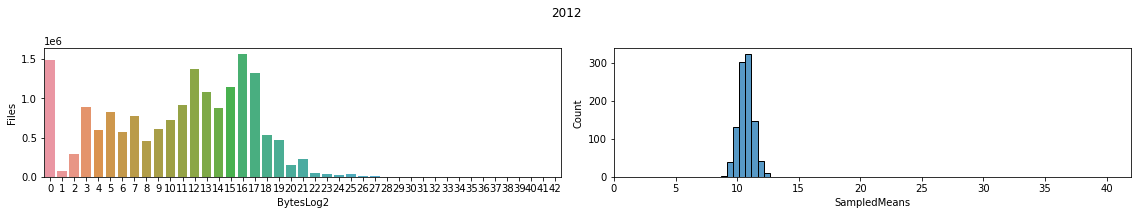

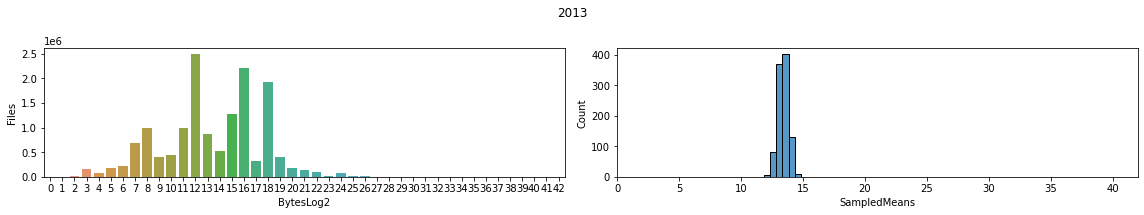

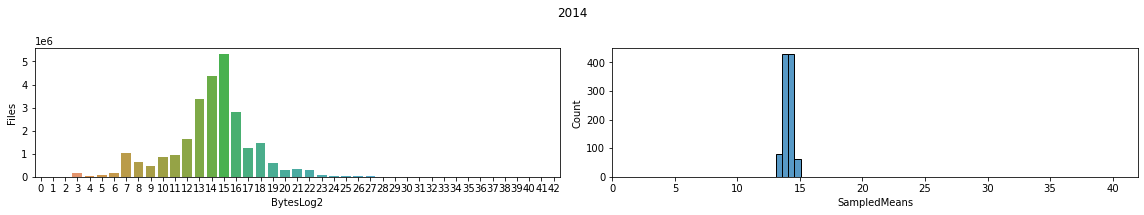

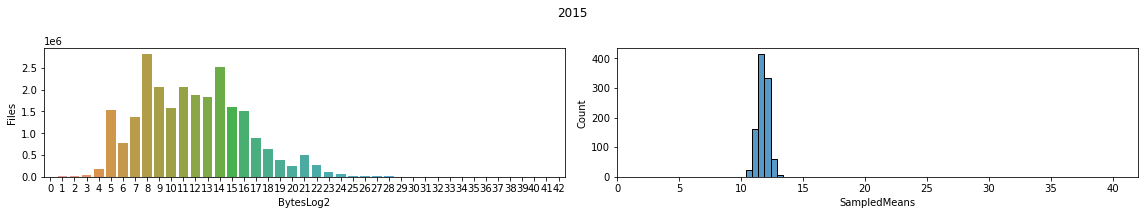

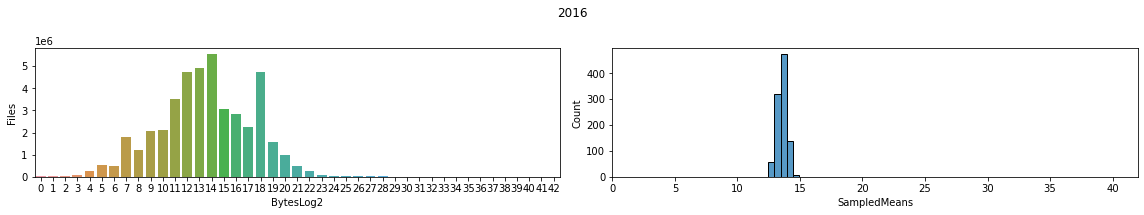

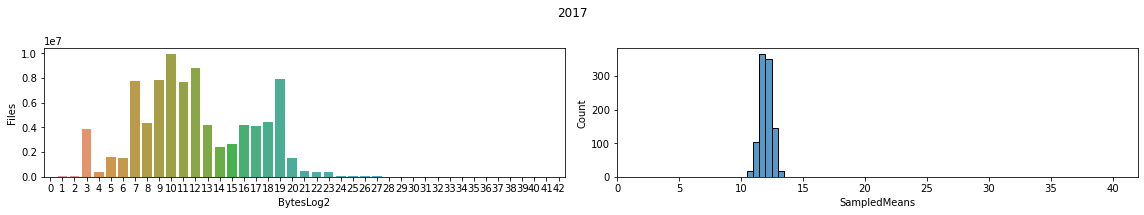

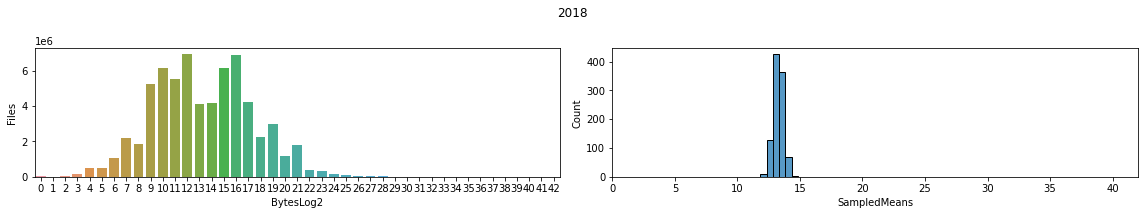

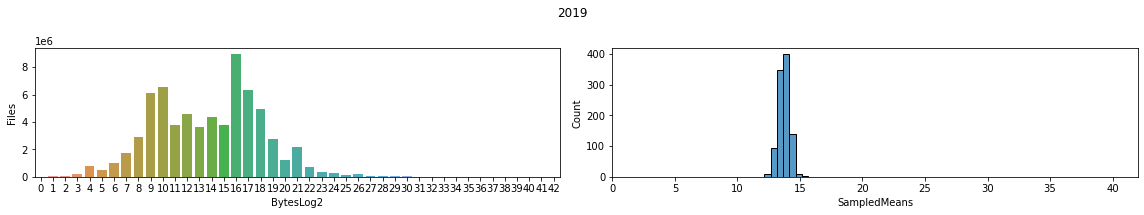

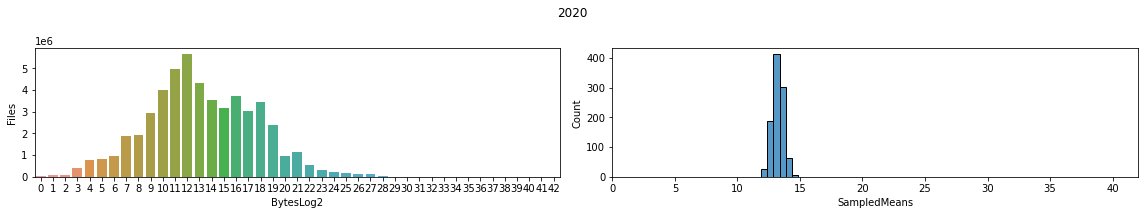

In [27]:
for (year, real_data), (year_sampled, bootstrapped_data) in zip(yearly_bytes_sum.groupby('Year'), bootstrapped_yearly_means_distribution.groupby('Year')):
    figure, (ax1, ax2) = plt.subplots(1,2,figsize=(16,3))
    figure.suptitle(int(year))
    sb.barplot(x='BytesLog2', y='Files', data=real_data, ci=None, ax=ax1)
    sb.histplot(x='SampledMeans', binwidth=0.5, data=bootstrapped_data, ax=ax2)
    plt.xlim(left=min(yearly_bytes_sum['BytesLog2']), right=max(yearly_bytes_sum['BytesLog2']))
    plt.tight_layout()
    plt.savefig('file-distributions-%d_python.svg' % year)

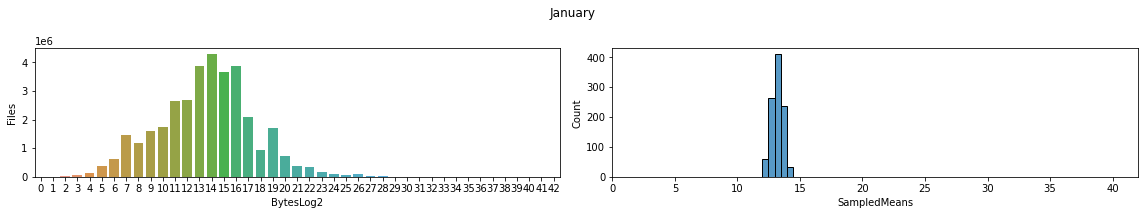

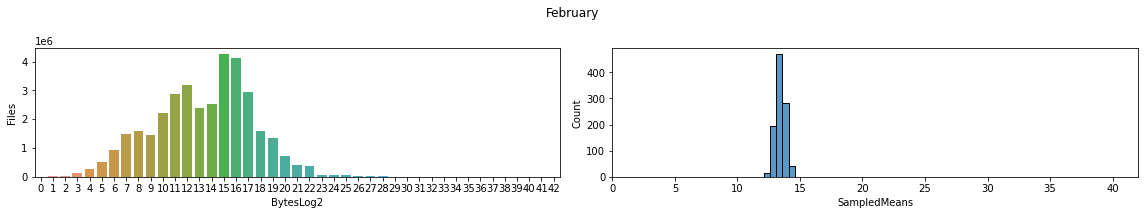

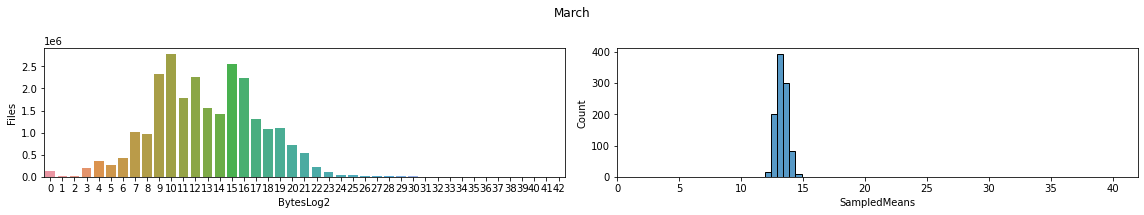

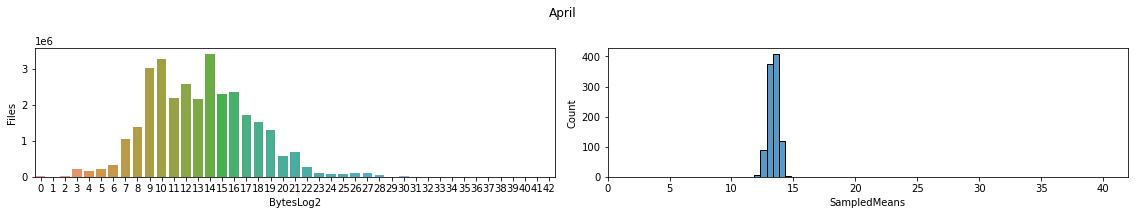

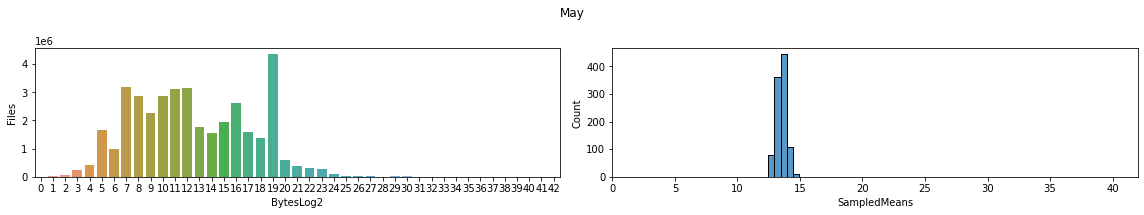

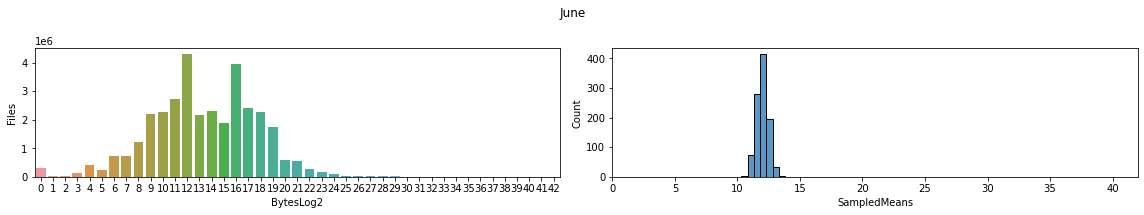

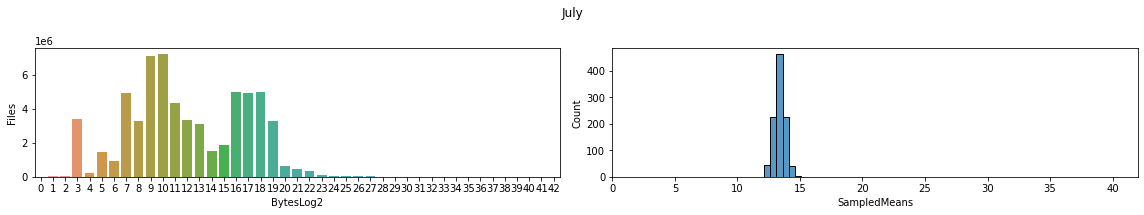

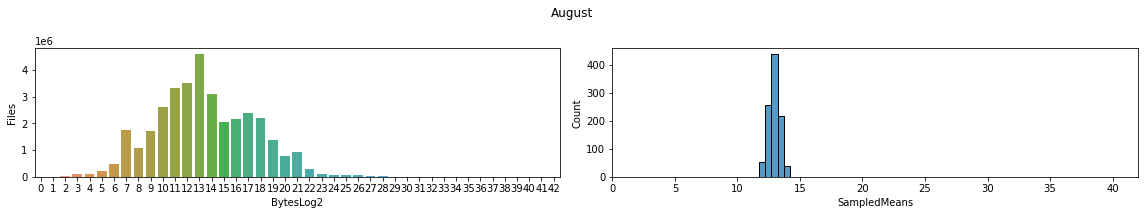

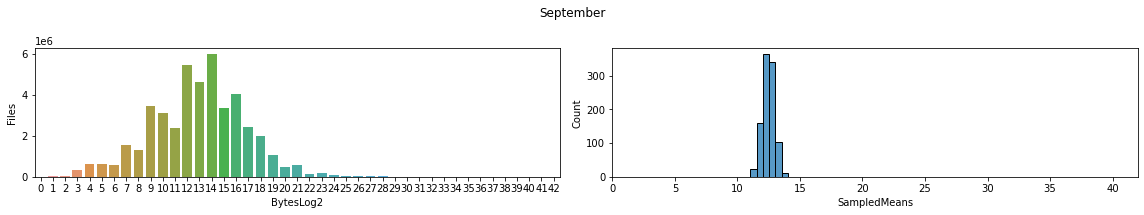

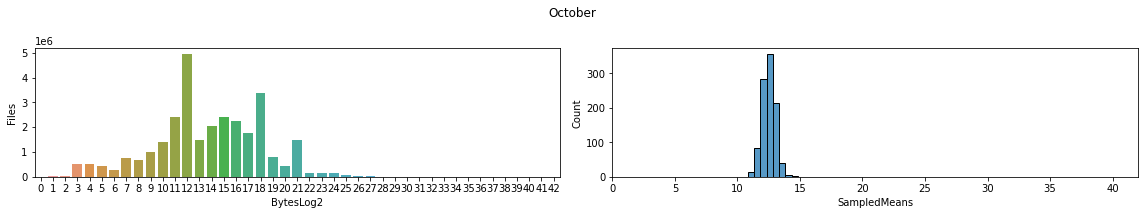

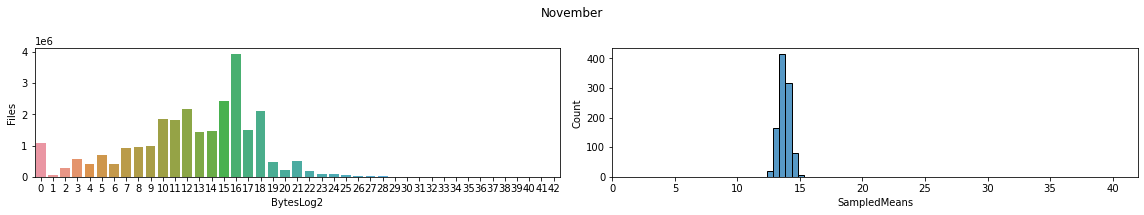

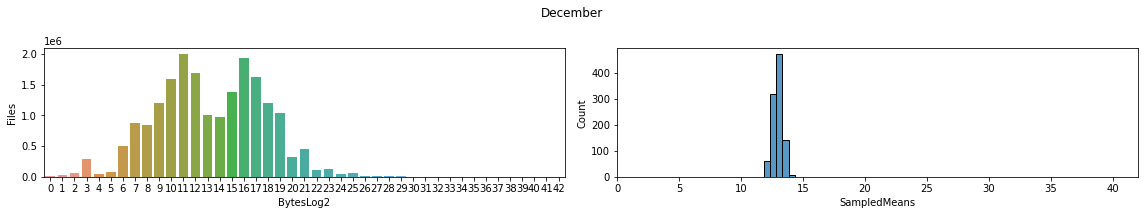

In [28]:
monthly_bytes_sum = aggregate_filesize_data(filesizes, ['Month','BytesLog2'], ['Files', 'SpaceUsage'], 'sum')
bootstrapped_monthly_means = bootstrap_byteslog2_mean(monthly_bytes_sum, 'Month', 'Files', n_means=1000)
bootstrapped_monthly_means_distribution = bootstrapped_monthly_means.drop('Mean', axis=1).explode('SampledMeans').reset_index()
bootstrapped_monthly_means_distribution.head()

for (month, real_data), (month_sampled, bootstrapped_data) in zip(monthly_bytes_sum.groupby('Month'), bootstrapped_monthly_means_distribution.groupby('Month')):
    figure, (ax1, ax2) = plt.subplots(1,2,figsize=(16,3))
    figure.suptitle(month)
    sb.barplot(x='BytesLog2', y='Files', data=real_data, ci=None, ax=ax1)
    sb.histplot(x='SampledMeans', binwidth=0.5, data=bootstrapped_data, ax=ax2)
    plt.xlim(left=min(yearly_bytes_sum['BytesLog2']), right=max(yearly_bytes_sum['BytesLog2']))
    plt.tight_layout()
    plt.savefig('file-distributions-%s_python.svg' % month)